# W4671 Final Project

## Using DNABert to Improve Microbiome OTU clustering for Colorectal Cancer Prediction

## George Austin, gia2105

### Data Setup

In [1]:
# setups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import biom
import tqdm

#from sbert_wk_functions import create_embeddings


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### DNABERT stuff
import sys
sys.path.append("../DNABERT/examples/data_process_template")
sys.path.append("../DNABERT/examples/")
sys.path.append("../DNABERT/src")
import process_690
import run_pretrain
import run_finetune

### Dataset stuff

#### pulling the reads
kmer = 6
reads_path = '../MicrobiomeHD_data/crc_baxter_results/crc_baxter.otu_seqs.100.fasta'
reads_ = pd.read_csv(reads_path, sep = ',', header = None)


# for the first reads_path

qq = 5

__ = reads_.iloc[range(reads_.shape[0])[1::qq]].reset_index()[0]
for i in range(2, qq):
    __ = __ + reads_.iloc[range(reads_.shape[0])[i::qq]].reset_index()[0]
    


reads = pd.DataFrame(\
 {'label':reads_.iloc[range(reads_.shape[0])[::qq]].reset_index()[0] ,\
  'elements':__
  })
reads['label'] = reads.label.str[1:]

# reads = pd.DataFrame(\
#  {'label':reads_.iloc[range(reads_.shape[0])[::qq]].reset_index()[0] ,\
#   'elements': reads_.iloc[range(reads_.shape[0])[1::qq]].reset_index()[0]
#   })
# reads['label'] = reads.label.str[1:]

## getting data in the right format for DNAbert
def kmerify(row):
    return(process_690.get_kmer_sentence( row.elements, kmer=6))


reads['kmers'] = reads.apply( kmerify, axis = 1 )


## setting up DNABert model
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple
from copy import deepcopy
from multiprocessing import Pool

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

# a lot of this code is from DNABert's repo
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertModel,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
    DNATokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

MODEL_CLASSES = {
    "gpt2": (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    "openai-gpt": (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    "dna": (BertConfig, BertForMaskedLM, DNATokenizer),
    "bert": (BertConfig, BertForMaskedLM, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForMaskedLM, CamembertTokenizer),
}

## standard code for loading pretrained huggingface model
config_class, model_class, tokenizer_class = MODEL_CLASSES['dna']

config = config_class.from_pretrained('../DNABERT_model_6/',\
                                      cache_dir='cache/')
config.output_hidden_states = True

tokenizer = tokenizer_class.from_pretrained('../DNABERT_model_6/',\
                                cache_dir='cache/')

model = BertModel.from_pretrained(  '../DNABERT_model_6',
            cache_dir= 'cache/',
            config = config)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
reads.elements.nunique()

122510

In [3]:
reads.tail()

,label,elements,kmers
122505,denovo122506,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTA ACGTAT CGTATG GTATGG TATGGT ATGGTG TGGT...
122506,denovo122507,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTA ACGTAG CGTAGG GTAGGG TAGGGG AGGGGG GGGG...
122507,denovo122508,TACGTAGGGAGCGAGCGTTATCCGGATTTATTGGGTGTAAAGGGTG...,TACGTA ACGTAG CGTAGG GTAGGG TAGGGA AGGGAG GGGA...
122508,denovo122509,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,TACGGA ACGGAG CGGAGG GGAGGA GAGGAT AGGATG GGAT...
122509,denovo122510,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTA ACGTAG CGTAGG GTAGGG TAGGGG AGGGGG GGGG...


## Loading OTU counts to see which OTUs are more common. For this dataset we only keep those whose abundance sum across all datapoints is > .001. 

In [4]:
# reading/set up the otu abundance matrix
path = '../MicrobiomeHD_data/crc_baxter_results/crc_baxter.otu_table.100.denovo'

df = pd.read_csv(path, sep = '\t')
df.index = df[df.columns[0]]
df_fixed = df.drop(df.columns[0], axis = 1).transpose()
df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
df_fixed = df_fixed[list( df_fixed.columns.dropna() )]
df_fixed = df_fixed[[a for a in reads.label]]
significant_otu_idx = df_fixed.sum(axis = 0) > (.001)
df_fixed = df_fixed.loc[:,significant_otu_idx]
df_fixed.head()

OTU_ID,denovo1,denovo2,denovo3,denovo4,denovo5,denovo6,denovo7,denovo8,denovo9,denovo10,...,denovo120946,denovo121283,denovo121648,denovo121684,denovo121688,denovo121899,denovo121915,denovo121938,denovo122248,denovo122311
2045653,0.123564,0.007887,0.001799,0.000415,0.010793,0.065587,0.004289,0.028227,0.038605,0.012730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2087650,0.041667,0.038889,0.005556,0.000000,0.090278,0.001389,0.002778,0.047917,0.029861,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2963670,0.022723,0.018890,0.000028,0.080109,0.008218,0.007032,0.035298,0.022089,0.003144,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2527670,0.002650,0.002650,0.033121,0.000000,0.010864,0.000795,0.000265,0.004769,0.008214,0.000265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3453650,0.041965,0.000000,0.017488,0.000050,0.001766,0.025871,0.012761,0.005274,0.005249,0.038060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
reads.head()

,label,elements,kmers
0,denovo1,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTA ACGTAG CGTAGG GTAGGG TAGGGG AGGGGG GGGG...
1,denovo2,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTA ACGTAG CGTAGG GTAGGG TAGGGG AGGGGG GGGG...
2,denovo3,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,TACGGA ACGGAG CGGAGG GGAGGA GAGGAT AGGATC GGAT...
3,denovo4,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,TACAGA ACAGAG CAGAGG AGAGGT GAGGTC AGGTCT GGTC...
4,denovo5,TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,TACGTA ACGTAT CGTATG GTATGG TATGGT ATGGTG TGGT...


In [6]:
reads = reads.loc[reads.label.isin(df_fixed.columns)].reset_index(drop = True)
#reads_long = reads_long.loc[reads_long.label.isin(df_fixed.columns)].reset_index(drop = True)
#embeddings = embeddings__[reads.index]
#(df_fixed.sum(axis = 0) > (.001) )

In [7]:
reads.shape

(13617, 3)

## Create the DNABert Embeddings

In [8]:
from sbert_wk_functions import create_embeddings

In [9]:
%%time

# n = 20 #doing the encoding in batch size of 20 on cpu
# subsets = [list(reads.kmers)[x:x+n] for x in range(0, len(list(reads.kmers)), n)]
# out = ['']*len(subsets)
# for i in tqdm.tqdm(range(len(subsets))):
#     out[i] = create_embeddings( subsets[i], model, tokenizer)
    
#     if i%100 == 0 and i > 0:
#         np.save('baxter_embeddings', np.vstack(out[:i]), allow_pickle = True)
        
# embeddings = np.vstack(out)
# np.save('baxter_embeddings', embeddings, allow_pickle = True)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


In [10]:
#writing fasta file to run sumaclust on the reduced dataset
def writeFasta(data, filename):
    ofile = open(filename, "w")
    fastaLines = []
    for rowNum in range(data.shape[0]):
        #fastaLines.append(">" + data.iloc[rowNum,0]  ')
        ofile.write( ">" + data.iloc[rowNum,0] + '\n' )
        ofile.write(data.iloc[rowNum, 1] + '\n')          
        #fastaLines.append( data.iloc[rowNum,1].upper())
    ofile.close()
    return(fastaLines)

In [11]:
writeFasta(reads, 'testing.fasta')

[]

In [12]:
embeddings = np.load('baxter_embeddings.npy')

In [13]:
embeddings.shape

(13617, 768)

## Get Similarity Matrix

In [14]:
%%time
from sklearn.metrics import pairwise_distances
sims = 1 - pairwise_distances(embeddings, metric = 'cosine')

CPU times: user 5.62 s, sys: 1.02 s, total: 6.63 s
Wall time: 6.68 s


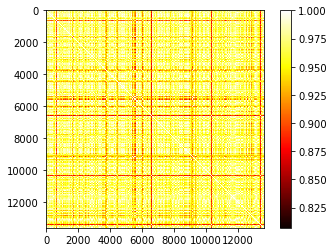

In [15]:
plt.imshow(sims, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

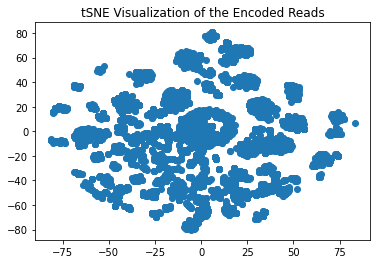

In [16]:
#visualizing representations of the reads
pc = PCA(n_components = 100)
ts = TSNE(n_components = 2, perplexity = 30)

viz = ts.fit_transform( pc.fit_transform(embeddings) )
plt.scatter(viz[:,0], viz[:, 1])
plt.title('tSNE Visualization of the Encoded Reads')
plt.show()

In [17]:
from sklearn.cluster import KMeans

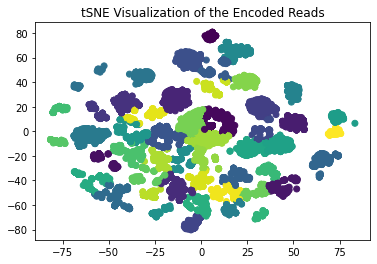

In [18]:
km = KMeans(n_clusters = 50)
km.fit(viz)
plt.scatter(viz[:,0], viz[:, 1], c = km.labels_)
plt.title('tSNE Visualization of the Encoded Reads')
plt.show()

## Load Metadata

In [19]:
metadata_path = '../MicrobiomeHD_data/crc_baxter_results/crc_baxter.metadata.txt'

metadata = pd.read_csv(metadata_path, sep = '\t', encoding = 'latin1')
metadata.columns

Index(['Sample_Name_s', 'Abx_s', 'Age_s', 'Asian_s', 'BMI_s', 'BioSample_s',
       'Black_s', 'Diabetes_Med_s', 'Diabetic_s', 'Ethnic_s', 'Experiment_s',
       'Gender_s', 'Height_s', 'Hx_Fam_CRC_s', 'Hx_Prev_s', 'Hx_of_Polyps_s',
       'Library_Name_s', 'MBases_l', 'MBytes_l', 'NSAID_s', 'Native_s',
       'Organism_s', 'Other_s', 'Pacific_s', 'Run_s', 'SRA_Sample_s',
       'Smoke_s', 'Weight_s', 'White_s', 'cancer_stage_s', 'chimera_check_s',
       'description_s', 'diagnosis_s', 'env_biome_s', 'env_feature_s',
       'env_material_s', 'fit_result_s', 'geo_loc_name_s', 'host_s',
       'lib_const_meth_s', 'organism_s', 'pcr_cond_s', 'pcr_primers_s',
       'samp_collect_device_s', 'samp_store_temp_s', 'sample_title_s',
       'seq_methods_s', 'seq_qual_check_s', 'target_gene_s',
       'target_subfragment_s', 'Assay_Type_s', 'AssemblyName_s',
       'BioProject_s', 'BioSampleModel_s', 'Center_Name_s', 'Consent_s',
       'InsertSize_l', 'LibraryLayout_s', 'LibrarySelection_s',
 

In [20]:
metadata.drop(['SRA_Study_s', 'g1k_analysis_group_s', 'g1k_pop_code_s', 'source_s',
       'dataset', 'sequencer', 'region', 'total_reads', 'study', 
              'geo_loc_name_s', 'host_s',
       'lib_const_meth_s', 'organism_s', 'pcr_cond_s', 'pcr_primers_s',
       'samp_collect_device_s', 'samp_store_temp_s', 'sample_title_s',
       'seq_methods_s', 'seq_qual_check_s', 'target_gene_s',
       'target_subfragment_s', 'Assay_Type_s', 'AssemblyName_s',
       'BioProject_s', 'BioSampleModel_s', 'Center_Name_s', 'Consent_s',
       'InsertSize_l', 'LibraryLayout_s', 'LibrarySelection_s',
       'LibrarySource_s', 'LoadDate_s', 'Platform_s', 'ReleaseDate_s', 
              'cancer_stage_s', 'chimera_check_s',
       'description_s', 'diagnosis_s', 'env_biome_s', 'env_feature_s',
       'env_material_s', 'fit_result_s', 'BioSample_s', 'Organism_s', 
              'Experiment_s'], axis = 1)

,Sample_Name_s,Abx_s,Age_s,Asian_s,BMI_s,Black_s,Diabetes_Med_s,Diabetic_s,Ethnic_s,Gender_s,...,NSAID_s,Native_s,Other_s,Pacific_s,Run_s,SRA_Sample_s,Smoke_s,Weight_s,White_s,DiseaseState
0,2005650,0,61,0,28.0,0,0,0,0,male,...,0,0,0,0,SRR2143517,SRS1022653,0,78,1,H
1,2003650,0,64,0,36.2,0,0,0,0,male,...,0,0,0,0,SRR2143516,SRS1022654,0,120,1,H
2,2027653,0,65,0,21.5,0,0,0,1,female,...,0,0,0,0,SRR2143527,SRS1022655,0,60,1,H
3,2025653,0,67,0,20.8,0,0,0,0,male,...,0,0,0,0,SRR2143526,SRS1022656,1,58,1,CRC
4,2023680,0,63,0,22.8,0,0,0,0,female,...,0,0,0,0,SRR2143525,SRS1022657,1,54,1,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,3531650,0,53,0,33.6,0,0,0,0,female,...,0,0,0,0,SRR2144127,SRS1023244,0,86,1,H
486,3535650,0,75,0,27.2,0,0,0,0,male,...,1,0,0,0,SRR2144128,SRS1023243,1,93,1,nonCRC
487,3537650,0,56,0,27.0,0,0,0,0,female,...,0,0,0,0,SRR2144129,SRS1023256,0,69,1,H
488,3551650,0,77,0,23.7,0,0,0,0,male,...,1,0,0,0,SRR2144130,SRS1023255,1,83,1,nonCRC


In [21]:
# set up prediction task
metadata_path = '../MicrobiomeHD_data/crc_baxter_results/crc_baxter.metadata.txt'

metadata = pd.read_csv(metadata_path, sep = '\t', encoding = 'latin1')

metadata['Var'] = metadata.DiseaseState
metadata['#Sample ID'] = metadata['Sample_Name_s'].astype(str)
metadata = metadata.drop(['SRA_Study_s', 'g1k_analysis_group_s', 'g1k_pop_code_s', 'source_s',
       'dataset', 'sequencer', 'region', 'total_reads', 'study', 
              'geo_loc_name_s', 'host_s',
       'lib_const_meth_s', 'organism_s', 'pcr_cond_s', 'pcr_primers_s',
       'samp_collect_device_s', 'samp_store_temp_s', 'sample_title_s',
       'seq_methods_s', 'seq_qual_check_s', 'target_gene_s',
       'target_subfragment_s', 'Assay_Type_s', 'AssemblyName_s',
       'BioProject_s', 'BioSampleModel_s', 'Center_Name_s', 'Consent_s',
       'InsertSize_l', 'LibraryLayout_s', 'LibrarySelection_s',
       'LibrarySource_s', 'LoadDate_s', 'Platform_s', 'ReleaseDate_s', 
              'cancer_stage_s', 'chimera_check_s',
       'description_s', 'diagnosis_s', 'env_biome_s', 'env_feature_s',
       'env_material_s', 'BioSample_s', 'Organism_s', 
              'Experiment_s', 'DiseaseState', 'Sample_Name_s',
                         'Library_Name_s', 'Run_s', 'SRA_Sample_s' ], axis = 1)

metadata.BMI_s = metadata.BMI_s.replace('missing', 25).astype(float)
metadata.Height_s = metadata.Height_s.replace('missing', '180').astype(int)
metadata.Weight_s = metadata.Weight_s.replace('missing', '80').astype(int)
metadata.Gender_s = metadata.Gender_s == 'male'

#metadata = metadata[['#Sample ID', 'Var']]
#metadata.Var = metadata.Var != 'nonCRC'
metadata.head()

,Abx_s,Age_s,Asian_s,BMI_s,Black_s,Diabetes_Med_s,Diabetic_s,Ethnic_s,Gender_s,Height_s,...,NSAID_s,Native_s,Other_s,Pacific_s,Smoke_s,Weight_s,White_s,fit_result_s,Var,#Sample ID
0,0,61,0,28.0,0,0,0,0,True,167,...,0,0,0,0,0,78,1,0,H,2005650
1,0,64,0,36.2,0,0,0,0,True,182,...,0,0,0,0,0,120,1,0,H,2003650
2,0,65,0,21.5,0,0,0,1,False,167,...,0,0,0,0,0,60,1,0,H,2027653
3,0,67,0,20.8,0,0,0,0,True,167,...,0,0,0,0,1,58,1,1509,CRC,2025653
4,0,63,0,22.8,0,0,0,0,False,154,...,0,0,0,0,1,54,1,0,H,2023680


In [22]:
metadata.Var.value_counts()
#nonCRC == adenoma
#H == healthy

nonCRC    198
H         172
CRC       120
Name: Var, dtype: int64

## Evaluate Clusters

In [23]:
from test_models import *

### DNABERT CLusters

In [ ]:
%%time
#show performance of DNABert hierarchal clustering
L = []

for i in [df_fixed.shape[1], 8000, 6000, 4000, 2000, 1000, 500, 250, 100, 50, 25, 10]:
    print(i)
    L.append( test_reduced_dims(df_fixed, metadata.loc[metadata.Var != 'nonCRC'], sims, i, reads) )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \
                        + full_results.auc.astype(str).str[0:4]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = full_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Colorectal Cancer using DNABERT Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

13617


In [ ]:
# Mapping clusters to phylogeny, exploring the cases where the clusters differ,
# and how it relates to interpretable signals from logistic regression

phylos = pd.read_csv('../MicrobiomeHD_data/crc_baxter_results/RDP/crc_baxter.otu_table.100.denovo.rdp_assigned', sep = '\t')['Unnamed: 0']

otu_phylo = pd.DataFrame( \
        dict( {'otu':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[-1], 
        'phylogeny':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[:-1].str.join(' ') } ) 
          )
otu_phylo = otu_phylo.loc[otu_phylo.otu.isin(df_fixed.columns)].reset_index(drop = True)

# taking dimension of 1000, consistently giving good results
clusterer = AC(n_clusters=8000, linkage="average", affinity='precomputed')
clusterer.fit(sims)
reads['cluster'] = km.labels_# clusterer.labels_

merged_info = otu_phylo.merge(reads, how = 'inner', left_on = 'otu', right_on = 'label')[['otu', 'phylogeny', 'cluster']]


reduced = df_fixed.copy()
reduced.columns = reads.cluster
red = reduced.transpose()
reduced = red.groupby(red.index).sum().transpose()

response = metadata
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

PREDS = []
TRUES = []

kf = KFold(n_splits=5, random_state=None, shuffle=True)
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

rf = RandomForestClassifier(n_estimators=10)#penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

cluster_summaries = merged_info.groupby('cluster')['phylogeny'].agg(lambda x: dict(x.value_counts())).reset_index()

# cluster_summaries['coef'] = rf.coef_[0]

# # observing the clusters corresponding to significant coefficients
# for i in cluster_summaries.loc[cluster_summaries.coef != 0].index:
#     print(cluster_summaries.phylogeny[i])
#     print(cluster_summaries.coef[i])
result = permutation_importance(rf, X, y, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
print( cluster_summaries.phylogeny[sorted_idx[-1]] )

def get_amount_in_data(row):
    return( (otu_phylo.phylogeny == row ).sum() )

sig_ = cluster_summaries.iloc[sorted_idx[-1]].phylogeny 
[get_amount_in_data(row) for row in sig_.keys()]

In [ ]:
(otu_phylo.phylogeny == ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Prevotellaceae Prevotella').sum()

there are 126 - 72 = 54 'Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae Bacteroides' OTUs that are excluded from this cluster. Every observed phylogeny in the significant cluster has OTUs that are removed from the cluster. From comparing to the below phylogenetic cluster, these deviations are leading to significant improvement in performances. 

### Phylogenetic Clusters

In [ ]:
response = metadata  
G = []
for i in [1, 2, 3, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response.loc[response.Var != 'nonCRC'], i, otu_phylo) )
    

phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Grouping Dimension'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]


plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = phylo_results,\
             ci= 0, hue = 'Phylo Tree Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Colorectal Cancer using Phylogenetic Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
n_cutoffs = 7
cluster = merged_info.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')

reduced = df_fixed.copy()
reduced.columns = cluster
reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
#print(n_cutoffs, X.shape)
#taking the less common class as the positive response
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

phylo_group_results = pd.DataFrame(dict({ 'phylo':reduced.columns, 
                     'coef':rf.coef_[0] }))

for i in phylo_group_results.loc[phylo_group_results.coef != 0].index:
    print(phylo_group_results.phylo[i])
    print(phylo_group_results.coef[i])


### Sumaclust Clusters

In [ ]:
#show performance of sumaclust clustering
L = []
file_path = 'testing.fasta'
for threshold in [1, .99, .98, .95, .9, .85, .8]:
    print(threshold)
    L.append( test_reduced_sumaclust(df_fixed, metadata.loc[metadata.Var != 'nonCRC'],\
                                     threshold, file_path, reads, f = 'rf') )

sum_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

sum_results['Grouping Dimension'] = sum_results.n_dims.astype(str) + ', AUC = ' \
                        + sum_results.auc.astype(str).str[0:4]

import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot(x = 'fpr', y = 'tpr', 
             data = sum_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Colorectal Cancer using SUMACLUST Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Putting AUCs across all Cluster Methods onto one plot

In [ ]:
#show performance of sumaclust clustering
L = []
file_path = 'testing.fasta'
for threshold in list( np.linspace(.8, 1, 30) )*2:#*3:
    L.append( test_reduced_sumaclust(df_fixed, metadata.loc[metadata.Var != 'nonCRC'], threshold, file_path,  reads, f = 'rf') )

sum_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

sum_results['Grouping Dimension'] = sum_results.n_dims.astype(str) + ', AUC = ' \
                        + sum_results.auc.astype(str).str[0:4]

In [ ]:
L = []

for i in list(np.linspace(25, df_fixed.shape[1], 30, dtype = np.uint64))*2:#*3:
               # [df_fixed.shape[1], 500, 200, 100, 50, 40, 25]:
    i = int(i)
    L.append( test_reduced_dims(df_fixed, metadata.loc[metadata.Var != 'nonCRC'], sims, i, reads, f = 'rf') )

full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \

In [ ]:
response = metadata.loc[metadata.Var != 'nonCRC']  
G = []
for i in [1, 2, 3, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, otu_phylo, f = 'rf') )
    

phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Grouping Dimension'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]




In [ ]:
auc_summary = sum_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary_ = full_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary['Method'] = 'Sumaclust'
auc_summary_['Method'] = 'DNABert'
phylo_results['n_dims'] = phylo_results.n_cutoffs
auc_summary__ = phylo_results.groupby('n_dims')['auc'].mean().reset_index()
auc_summary__['Method'] = 'Phylogeny'

auc_summary = pd.concat((auc_summary, auc_summary_, auc_summary__), axis = 0)



auc_summary = pd.concat((auc_summary, auc_summary_), axis = 0)
sns.set_theme()
plt.figure(figsize=(10,5))
ax = sns.lineplot(x = 'n_dims', y = 'auc', 
             data = auc_summary,\
             ci= 0, hue = 'Method') 

#plt.title('Comparing Random Forest AUCs across Clustering Methods')
plt.xlabel("Number of Clusters", fontsize = 15)
plt.ylabel("AUC", fontsize = 15)
plt.legend(loc=4, title = 'Method')
plt.setp( ax.get_legend().get_texts(), fontsize='15')
plt.setp(ax.get_legend().get_title(), fontsize='20')
ax.tick_params(axis='both', which='major', labelsize=15)
#plt.savefig('Results/crc_baxter_rf.png', pad_inches = 0)
plt.show()